# The application of HHT to VERITAS pedvars - searching for transients
* Hilbert-Huang Transform (HHT) is analagous to a spectrogram in FFT or a scalogram in wavelet tranform. 
* Instead of FT or wavelet, HHT uses Hilbert transform to give instantaneous frequencies, which is only physically meaningful if the signal is narrow band (or monocomponent). 
* Therefore, HHT first uses empirical mode decomposition (EMD) to extract locally narrow-band components (called intrinsic mode functions; IMFs) using an adaptive basis solely determined from data. 
* The IMFs are found through a sifting process. In each sifting iteration, one IMF is found, which has 1) a zero mean and 2) the same number of zero crossings as local extrema. This implies that it is stationary, and captures the component with the highest frequency (fastest-varying component). The residual is then fed to the next round of sifting. 
* Ensemble EMD (EEMD) is used to avoid mode mixing. 


In [1]:
# see if we can run R in python
import rpy2
print(rpy2.__version__)
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.numpy2ri import numpy2ri



%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import seaborn as sns
    sns.set_style("ticks") 
    #sns.set_style({"axes.axisbelow": False})
    sns.set_style({"xtick.direction": "in" ,"ytick.direction": "in"})
except:
    print("sns problem")

from scipy import signal


import matplotlib





2.8.5


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html


In [2]:
def read_file(f="Run59775_Ch27"):
    df = pd.read_csv(f, sep=r"\s+", header=None, names=["pedvar", "dpedvar"])
    return df

df_test = read_file(f="Run59775_Ch27")




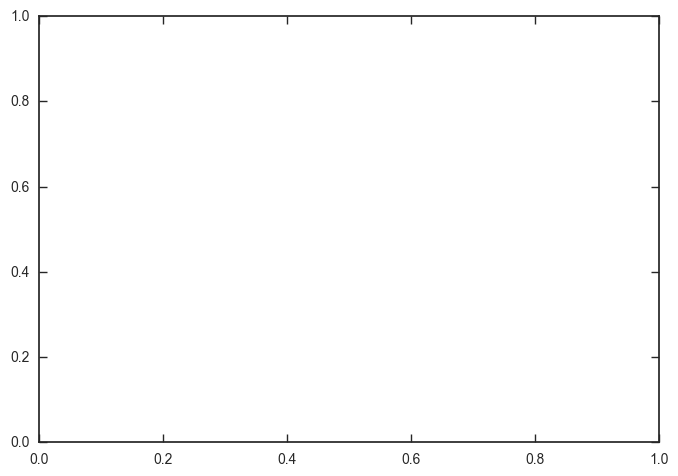

In [3]:
def plot_df(df, t=None, fig=plt.figure(), ax=plt.subplot(111), 
            xlabel="Bin number", ylabel="Pedestal variance", 
            xlim=None, ylim=None, label="Run59775_Ch27"):
    #fig=fig 
    #ax=ax
    if t is None:
        ax.errorbar(range(df.shape[0]), df.pedvar, yerr=df.dpedvar, label=label)
    else:
        ax.errorbar(t, df.pedvar, yerr=df.dpedvar, label=label)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    



In [107]:
def do_hht(fname, trial_dir="test/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True, fix_scale=None, residual_scale=None, 
          do_spec=True, dfreq=1e-4, show=True, logp=False, logf=False, logt=False):
    
    df1= read_file(f=fname)

    ro.r("library(hht)")
    ro.r("nimf <- {}".format(N_imf))
    ro.r("trials <- {}".format(N_trials))
    ro.r("imf.list <- 1:{}".format(N_imf_plot))

    ro.r("lc<-read.table(file=\"{}\", sep=\"\", header = FALSE)".format(fname))
    ro.r("lc<-lc[[\"V1\"]]")
    ro.r("sig<-lc")

    ro.r("N=length(sig)")
    ro.r("tn=seq(0,N-1)")
    ro.r("noise.amp <- {}".format(noise_amp))
    ro.r("trials.dir <- \"{}\"".format(trial_dir))
    ro.r("set.seed(628)")
    ro.r("EEMD(lc, tn , noise.amp, trials, nimf, trials.dir = trials.dir)")
    ro.r("EEMD.result <- EEMDCompile(trials.dir, trials, nimf)")
    ro.r("time.span <- c(0, N)")
    eemd_res = ro.r("EEMD.result")
    #time_span = ro.r("time.span")
    #ro.r("")
    
    dict_eemd = r2dict(eemd_res)

    if plot:
        _ = plot_imfs(dict_eemd, plot=True, fix_scale=fix_scale, residual_scale=residual_scale)
        if show:
            plt.show()
        
    if do_spec:
        dict_hspec, dict_hgram = calc_spec(dfreq=dfreq)
        if plot:
            plot_hgram(dict_eemd, dict_hgram, logp=logp, logt=logt, logf=logf, cm='viridis')
            if show:
                plt.show()

            plot_hspec(dict_eemd, dict_hspec, logt=logt, logp=logp)
            if show:
                plt.show()

        
    return dict_eemd, dict_hspec, dict_hgram

def do_hht_arr(arr, trial_dir="test/", N_trials=10, N_imf=10, N_imf_plot=8, 
               noise_amp=1e-6, plot=True, fix_scale=None, residual_scale=None, 
               do_spec=True, dfreq=1e-4, show=True, logp=False, logf=False, logt=False):
    
    ro.r("library(hht)")
    ro.r("nimf <- {}".format(N_imf))
    ro.r("trials <- {}".format(N_trials))
    ro.r("imf.list <- 1:{}".format(N_imf_plot))

    #ro.r("lc<-read.table(file=\"{}\", sep=\"\", header = FALSE)".format(t))
    #ro.r("lc<-lc[[\"V1\"]]")
    lc_ = ro.FloatVector(arr)
    ro.globalenv['lc_'] = lc_
    ro.r("sig<-lc_")

    ro.r("N=length(sig)")
    ro.r("tn=seq(0,N-1)")
    ro.r("noise.amp <- {}".format(noise_amp))
    ro.r("trials.dir <- \"{}\"".format(trial_dir))
    ro.r("set.seed(628)")
    ro.r("EEMD(lc_, tn , noise.amp, trials, nimf, trials.dir = trials.dir)")
    ro.r("EEMD.result <- EEMDCompile(trials.dir, trials, nimf)")
    ro.r("time.span <- c(0, N)")
    eemd_res = ro.r("EEMD.result")
    #time_span = ro.r("time.span")
    #ro.r("")
    
    dict_eemd = r2dict(eemd_res)
    if plot:
        _ = plot_imfs(dict_eemd, plot=True, fix_scale=fix_scale, residual_scale=residual_scale)
        if show:
            plt.show()

        
    if do_spec:
        dict_hspec, dict_hgram = calc_spec(dfreq=dfreq)
        if plot:
            plot_hgram(dict_eemd, dict_hgram, logp=logp, logt=logt, logf=logf, cm='viridis')
            if show:
                plt.show()

            plot_hspec(dict_eemd, dict_hspec, logp=logp, logt=logt)
            if show:
                plt.show()

    return dict_eemd, dict_hspec, dict_hgram



def calc_spec(dfreq=1e-4):
    ro.r("hres=EEMD.result")
    ro.r("dfreq={}".format(dfreq))
    ro.r("dt=1")
    ro.r("hgram <- HHRender(hres, dt, dfreq, time.span = NULL, \
         freq.span = NULL, scaling = \"none\", combine.imfs = TRUE, verbose = TRUE)")

    ro.r("hspec <- HHSpectrum(hres,dfreq,scaling = \"none\")")

    hgram = ro.r("hgram")
    hspec = ro.r("hspec")
    dict_hgram = r2dict(hgram)
    dict_hspec = r2dict(hspec)
    return dict_hspec, dict_hgram


def plot_imfs(dict_eemd, plot=True, fix_scale=None, residual_scale=None):
    #df_eemd = pandas2ri.ri2py(eemd_res)
    #dict_eemd = dict(zip(df_eemd.names, map(list,list(df_eemd))))
    N_t = len(dict_eemd['original.signal'])
    N_imfs = dict_eemd['nimf'][0]
    imfs = dict_eemd['averaged.imfs']
    N_all_imfs = len(imfs)
    original_signal = dict_eemd['original.signal']
    residual = dict_eemd['averaged.residue']
    tt = dict_eemd['tt']

    if plot:
        fig, axes = plt.subplots(N_imfs+2, 1, figsize=(8, 8./4*(N_imfs+2)))

        axes[0].plot(tt, original_signal, label="Original signal")
        axes[0].legend()
        #if fix_scale is not None:
        #    axes[0].set_ylim(fix_scale)
        for i in range(N_imfs):
            axes[i+1].plot(tt, imfs[N_t*i:N_t*(i+1)], label="IMF {}".format(i+1))
            axes[i+1].legend()
            if fix_scale is not None:
                axes[i+1].set_ylim(fix_scale)
        axes[-1].plot(tt, residual, label="Residual")
        axes[-1].legend()
        if residual_scale is not None:
                axes[-1].set_ylim(residual_scale)
    return dict_eemd


def plot_hgram(dict_eemd_res3, dict_hgram, logp=False,
               logf=False, logt=False, cm='viridis'):
    nt = len(dict_hgram['tt'])
    cm_viridis=matplotlib.cm.get_cmap(cm)
    #fig = plt.figure(facecolor=cm_viridis(0))

    for i in range(dict_eemd_res3['nimf'][0]):
        for j in range(10):
            if logp:
                plt.scatter(dict_hgram['tt'], dict_hgram['hinstfreq'][(i*10+j*1)*nt:((i)*10+(j+1)*1)*nt], 
                        c=np.log(dict_hgram['hamp'][(i*10+j*1)*nt:((i)*10+(j+1)*1)*nt]), marker=".", cmap=cm)
            else:
                plt.scatter(dict_hgram['tt'], dict_hgram['hinstfreq'][(i*10+j*1)*nt:((i)*10+(j+1)*1)*nt], 
                        c=dict_hgram['hamp'][(i*10+j*1)*nt:((i)*10+(j+1)*1)*nt], marker=".", cmap=cm)
        #hspec_total += dict_hspec['amplitude'][i*nfreq:(i+1)*nfreq]

    ax = plt.gca()
    ax.set_axis_bgcolor(cm_viridis(0))
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #dict_hspec['frequency']


def plot_hspec(dict_eemd_res3, dict_hspec, logp=False, logt=False):
    #dict_eemd_res3 = r2dict(eemd_res3)
    dict_eemd_res3['nimf']
    nfreq = len(dict_hspec['frequency'])
    hspec_total = np.zeros(nfreq).astype(float)

    for i in range(dict_eemd_res3['nimf'][0]):
        plt.plot(dict_hspec['frequency'], dict_hspec['amplitude'][i*nfreq:(i+1)*nfreq], label="IMF {}".format(i+1))
        hspec_total += dict_hspec['amplitude'][i*nfreq:(i+1)*nfreq]

    plt.plot(dict_hspec['frequency'], hspec_total, label="Total")
    if logt:
        plt.xscale('log')
    if logp:
        plt.yscale('log')
    plt.legend()
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    #dict_hspec['frequency']




def r2dict(eemd_res):
    df_eemd = pandas2ri.ri2py(eemd_res)
    dict_eemd = dict(zip(df_eemd.names, map(list,list(df_eemd))))
    return dict_eemd



# Sanity checks:

[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


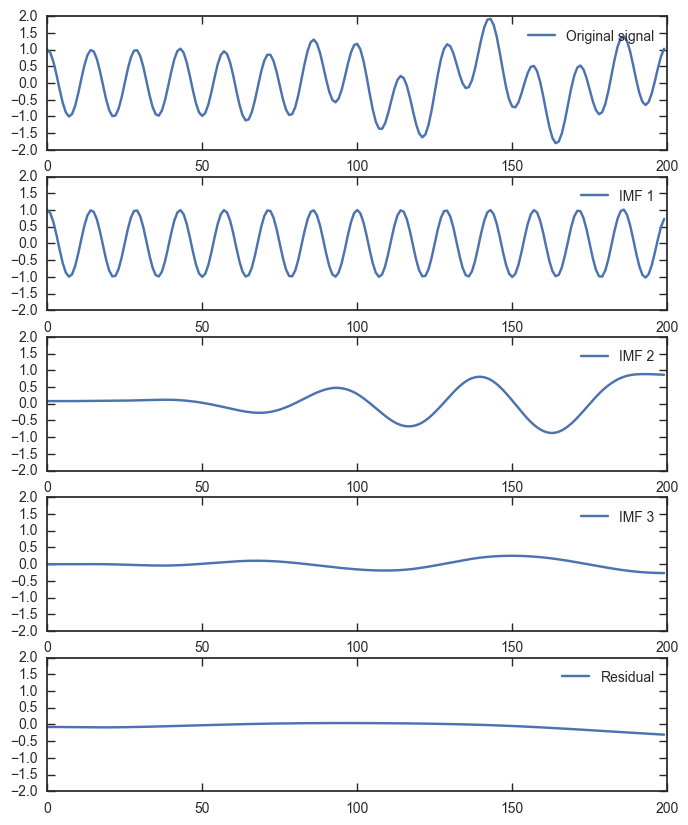

[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"


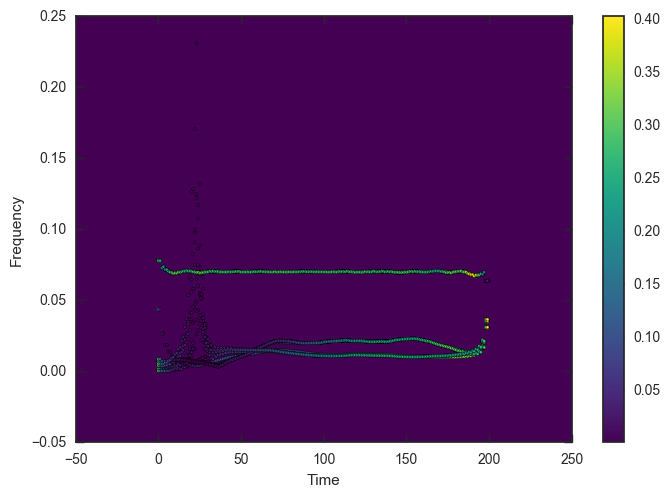

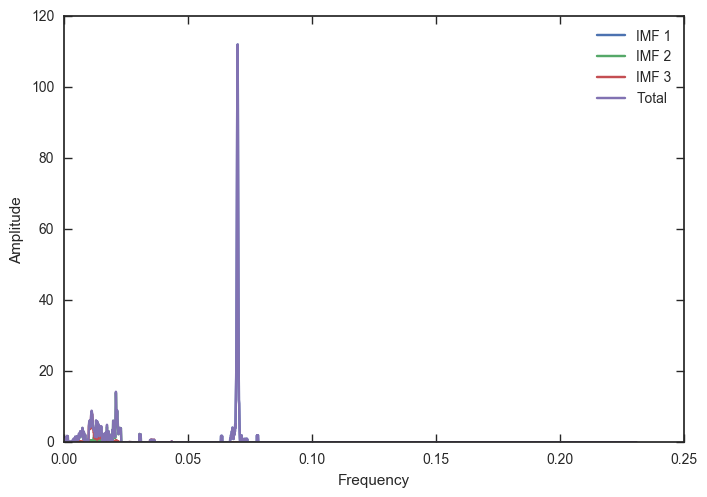

In [91]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

#plt.plot(t, sig)

dict_eemd_, dict_hspec_, dict_hgram_ = do_hht_arr(sig, trial_dir="test4/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-3, plot=True, fix_scale=[-2,2], residual_scale=[-2,2])



[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


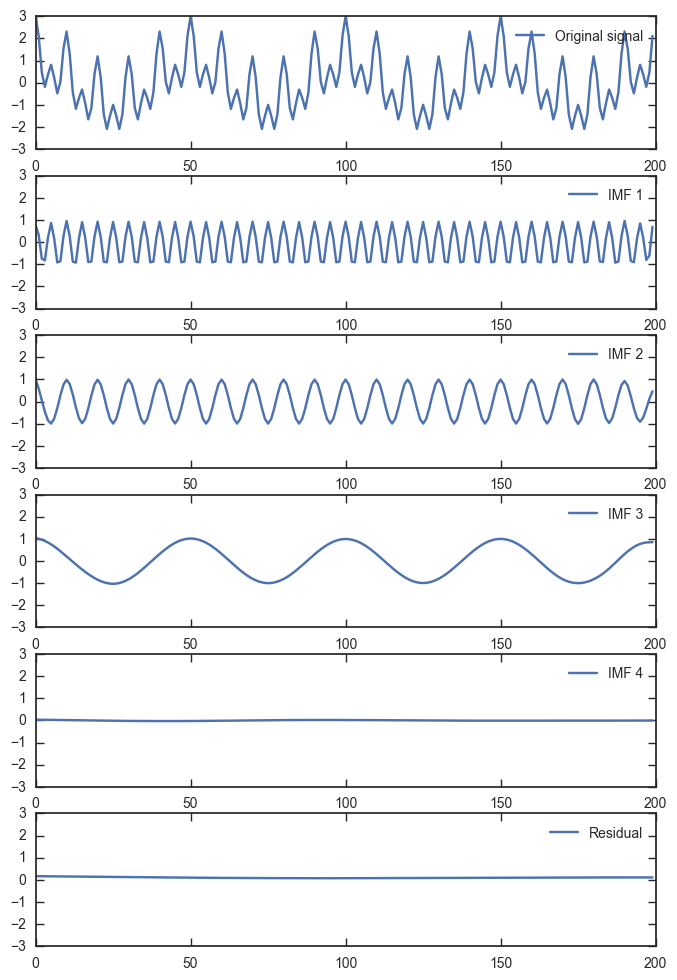

[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 4 COMPLETE!"
[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 4 COMPLETE!"


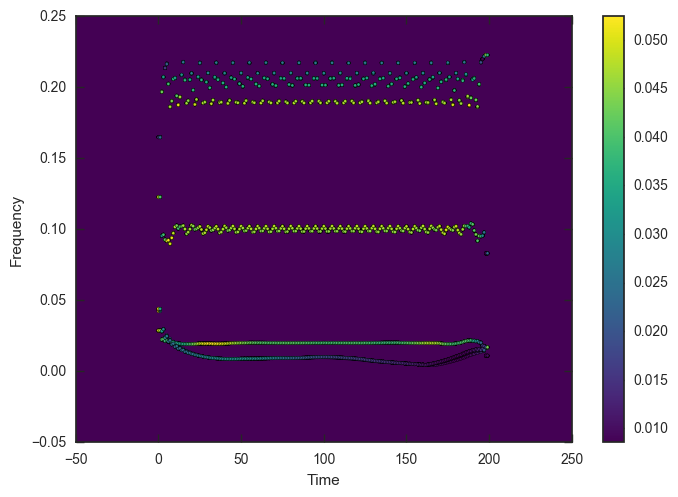

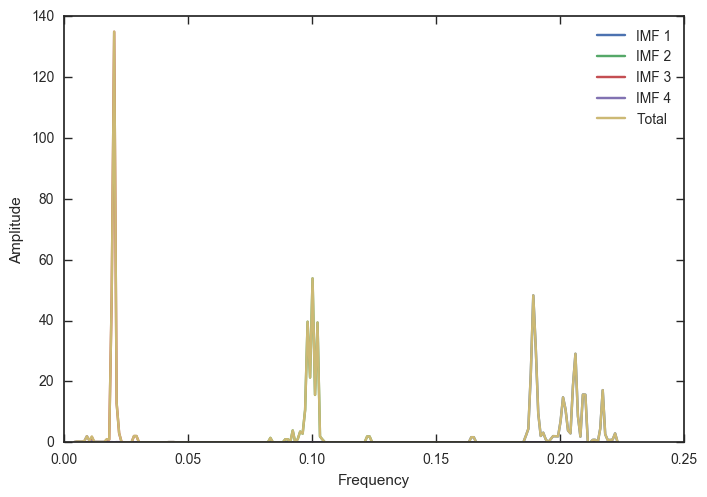

In [101]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 10 * t) + np.cos(2 * np.pi * 20 * t) + np.cos(2 * np.pi * 2 * t)

dict_eemd_, dict_hspec_, dict_hgram_ = do_hht_arr(sig, trial_dir="test4/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-3, plot=True, fix_scale=[-3,3], residual_scale=[-3,3], dfreq=1e-3)



# End of sanity check 

[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


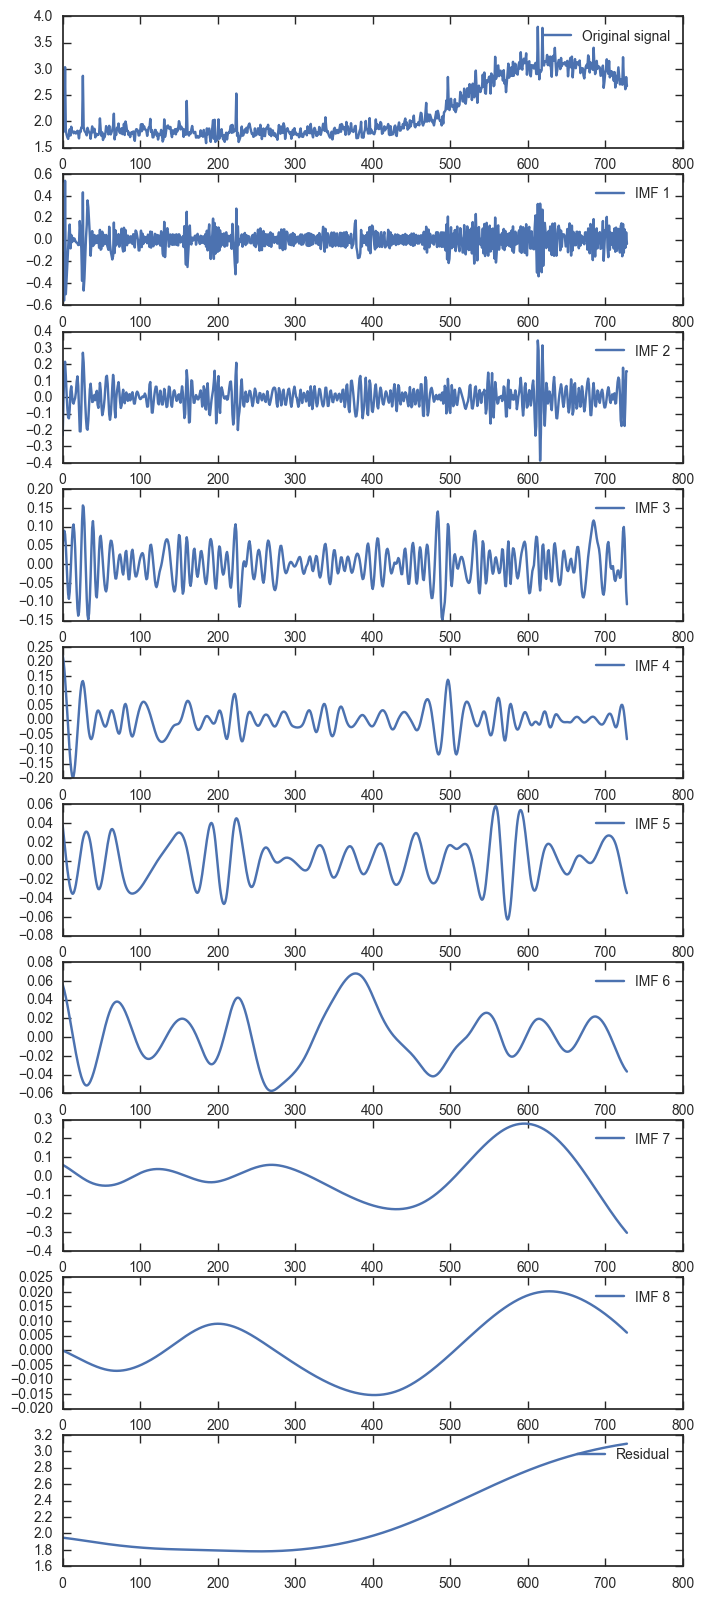

[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 4 COMPLETE!"
[1] "IMF 5 COMPLETE!"
[1] "IMF 6 COMPLETE!"
[1] "IMF 7 COMPLETE!"
[1] "IMF 8 COMPLETE!"
[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 4 COMPLETE!"
[1] "IMF 5 COMPLETE!"
[1] "IMF 6 COMPLETE!"
[1] "IMF 7 COMPLETE!"
[1] "IMF 8 COMPLETE!"


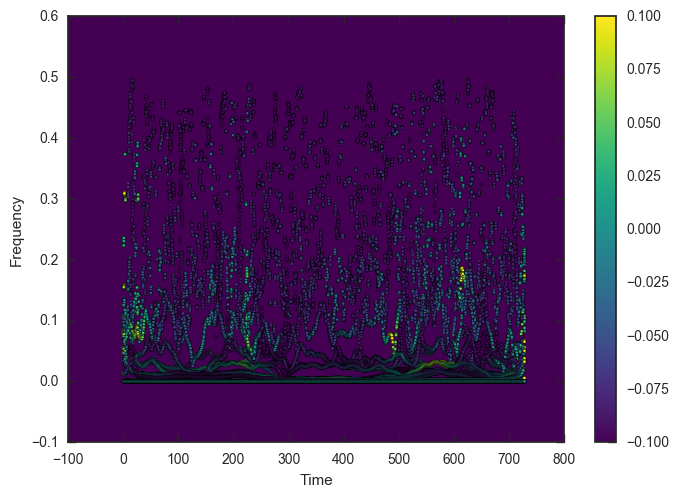

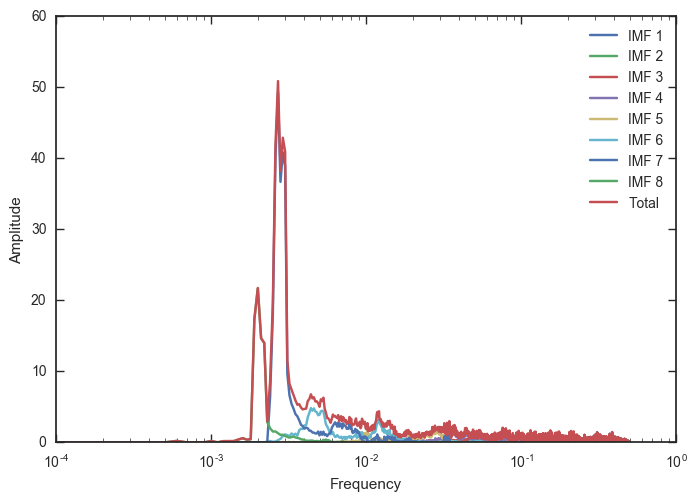

In [108]:
fname="Run59775_Ch356"

df1= read_file(f="Run59775_Ch356")
t = np.linspace(0, 30.*60., df1.shape[0], endpoint=False)
#plot_df(df1, t=t, fig=plt.figure(), ax=plt.subplot(111), xlabel="Approx. time", label="Run59775_Ch27")

eemd_res356 = do_hht(fname, trial_dir="testRun59775_Ch356/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-3, plot=True, logf=True, logt=True)





[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


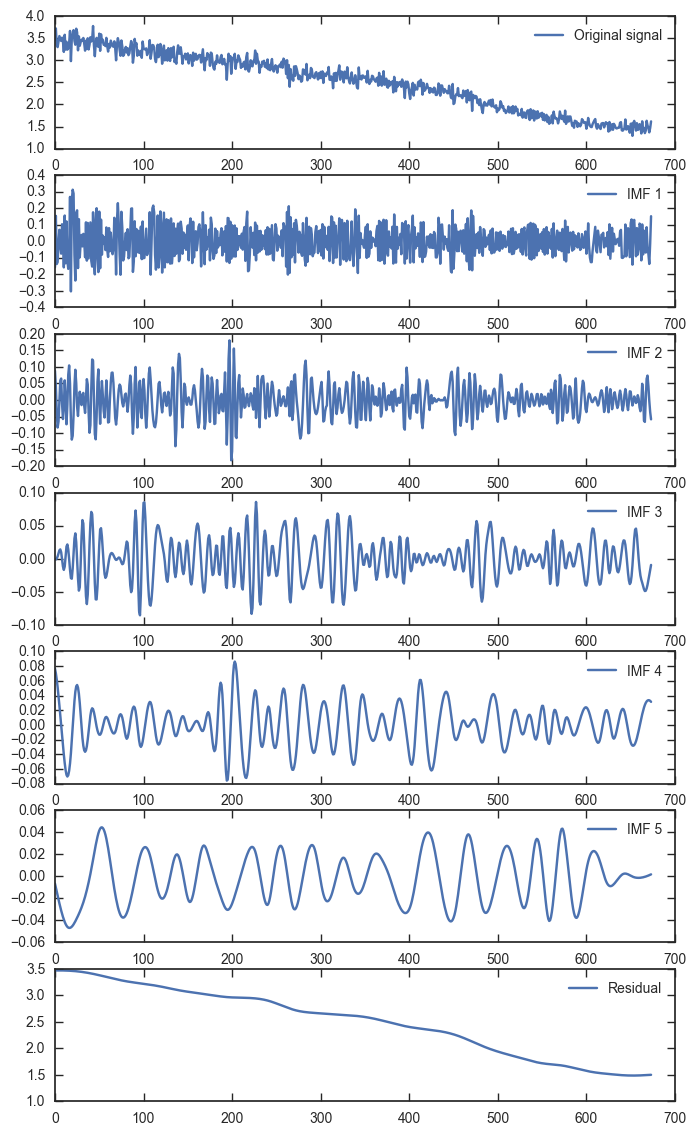

[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 4 COMPLETE!"
[1] "IMF 5 COMPLETE!"
[1] "IMF 1 COMPLETE!"
[1] "IMF 2 COMPLETE!"
[1] "IMF 3 COMPLETE!"
[1] "IMF 4 COMPLETE!"
[1] "IMF 5 COMPLETE!"


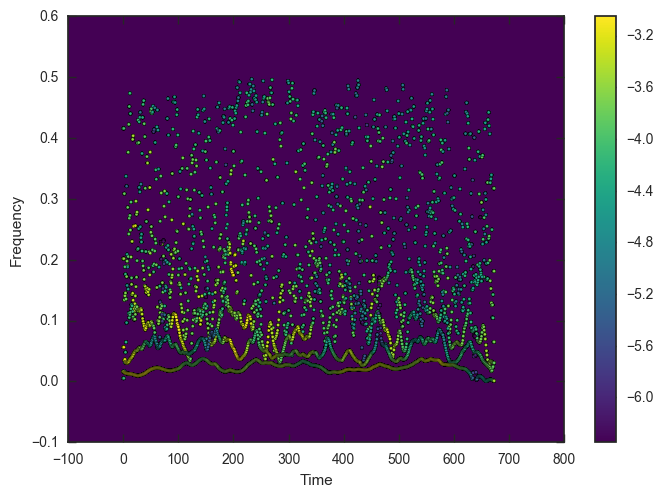

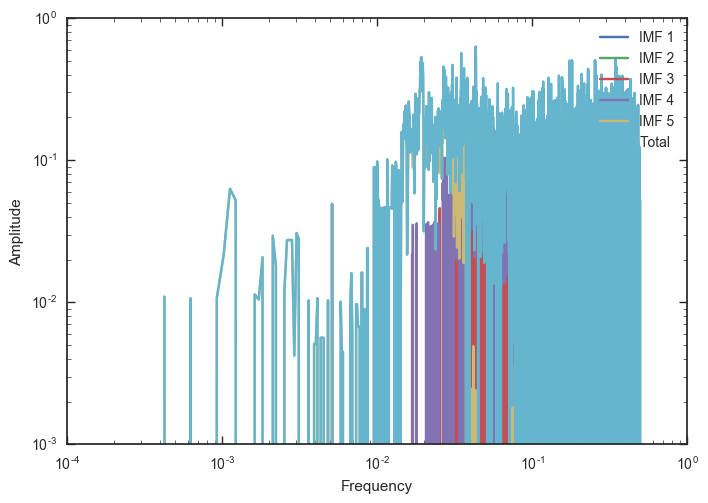

In [110]:
f3="Run59776_Ch194"

eemd_res3 = do_hht(f3, trial_dir="test3/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-5, plot=True, logp=True, logf=True, logt=True)


